# Sparse Hebbian Learning: basics

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=4, suppress=True)

In [3]:
from shl_scripts.shl_experiments import SHL

DEBUG_DOWNSCALE, verbose = 10, 0
DEBUG_DOWNSCALE, verbose = 1, 10
DEBUG_DOWNSCALE, verbose = 1, 0

In [4]:
help(SHL)

Help on class SHL in module shl_scripts.shl_experiments:

class SHL(builtins.object)
 |  Base class to define SHL experiments:
 |      - initialization
 |      - coding and learning
 |      - visualization
 |      - quantitative analysis
 |  
 |  Methods defined here:
 |  
 |  __init__(self, height=256, width=256, patch_size=(16, 16), database='database/', n_dictionary=324, learning_algorithm='mp', fit_tol=None, l0_sparseness=10, n_iter=16384, eta=0.01, eta_homeo=0.01, alpha_homeo=0, max_patches=1024, batch_size=256, record_each=200, n_image=200, DEBUG_DOWNSCALE=1, verbose=0, data_cache='./data_cache')
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  code(self, data, dico, coding_algorithm='mp', **kwargs)
 |  
 |  get_data(self, name_database='serre07_distractors', seed=None, patch_norm=True)
 |  
 |  learn_dico(self, data=None, name_database='serre07_distractors', matname=None, folder_exp=None, list_figures=[], fname=None, **kwargs)
 |  
 |  plot_varianc

In [5]:
shl = SHL(DEBUG_DOWNSCALE=DEBUG_DOWNSCALE, learning_algorithm='mp', verbose=verbose)
data = shl.get_data(name_database='serre07_distractors')

In [6]:
print('number of patches, size of patches = ', data.shape)
print('average of patches = ', data.mean())
print('average energy of patches = ', data.std(axis=0).mean())
print('std of the average of individual patches = ', data.mean(axis=0).std())

number of patches, size of patches =  (204800, 256)
average of patches =  2.67526886061e-19
average energy of patches =  1.0
std of the average of individual patches =  2.91369177713e-18


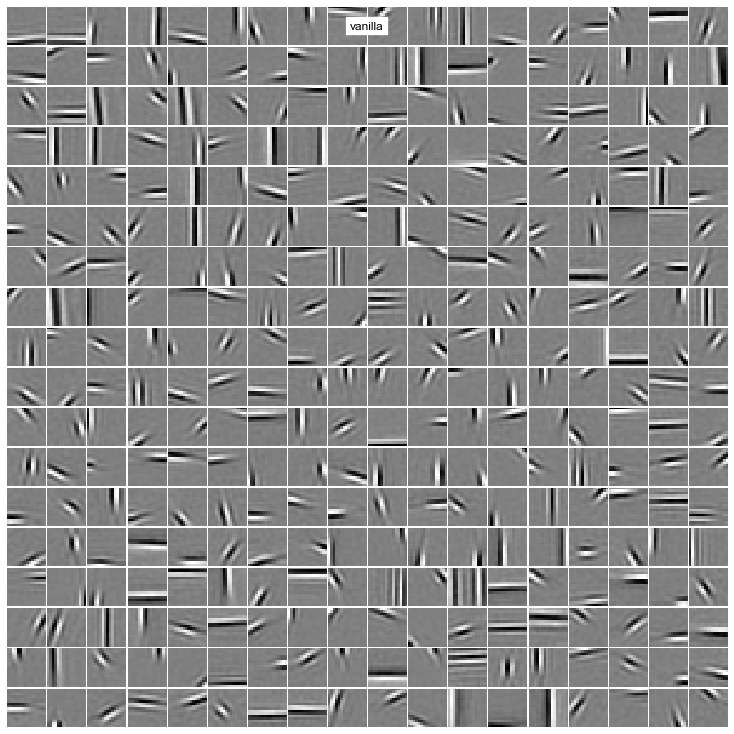

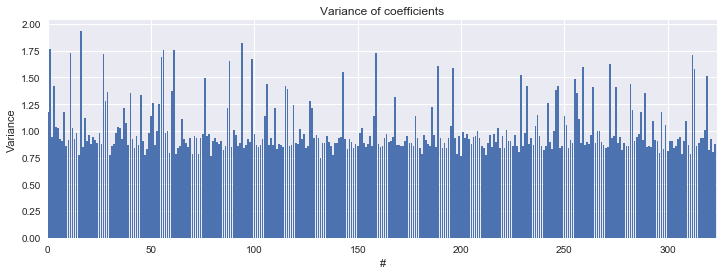

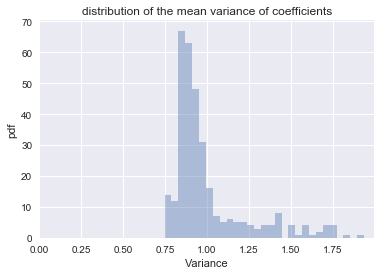

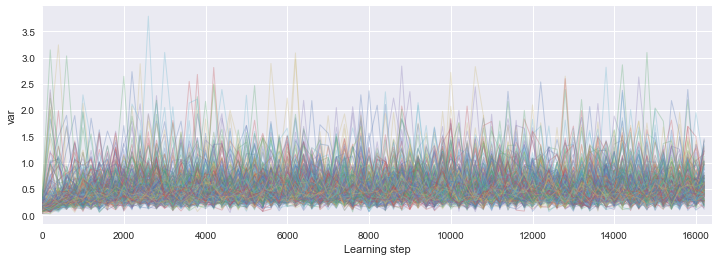

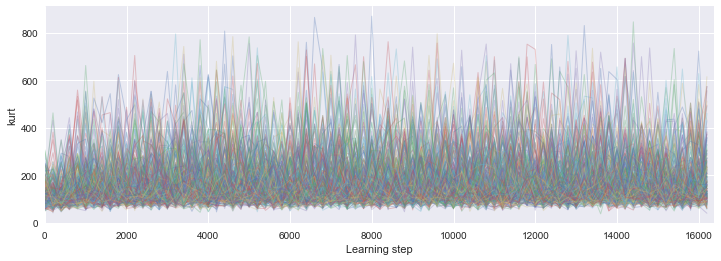

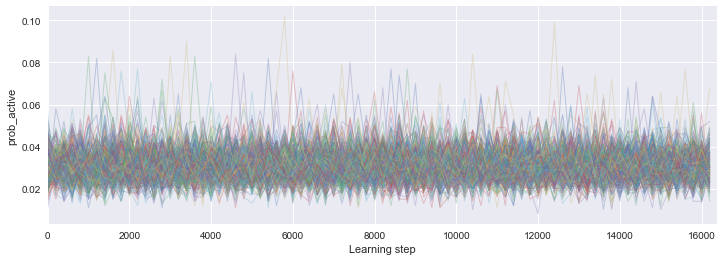

In [7]:
matname = 'vanilla'
list_figures = ['show_dico', 'plot_variance',  'plot_variance_histogram',  'time_plot_prob',  'time_plot_kurt',  'time_plot_var']

dico = shl.learn_dico(matname=matname, list_figures=list_figures)

In [8]:
patches = shl.code(data, dico)
print('number of patches, size of patches = ', patches.shape)
print('average of patches = ', patches.mean())
print('average energy of patches = ', patches.std(axis=0).mean())
print('std of the average of individual patches = ', patches.mean(axis=0).std())

AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
print(patches)

In [ ]:
code = dico.transform(data)
print('number of codes, size of codewords = ', code.shape)
print('average of codewords = ', code.mean())
print('average energy of patches = ', code.std(axis=0).mean())
print('std of the average of individual patches = ', code.mean(axis=0).std())

In [ ]:
error = data - patches
print('average of residual patches = ', error.mean())
print('average energy of residual patches = ', error.std(axis=0).mean())
print('std of the average of individual patches = ', error.mean(axis=0).std())

## Version used

In [ ]:
%load_ext version_information
%version_information numpy, shl_scripts